# Spotify Uploader
a project to automatically create and update playlists on Spotify based on your listening history

it also includes code for visualizing your listening history

# Setup

In [1]:
# Imports
!pip3 install --upgrade pip
!pip3 install pandas
!pip3 install numpy
!pip3 install spotipy
# !pip3 install pprint
!pip3 install requests
!pip install matplotlib
!pip install calplot
!pip install python-decouple
!pip install python-dotenv
# !pip install -r "requirements.txt"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 24.2
    Uninstalling pip-24.2:
      Successfully uninstalled pip-24.2


In [2]:
# make sure your python path is your virtual environment.
import sys
sys.executable

'/Users/awlego/Repositories/spotify_sync/env3.10/bin/python3.10'

In [3]:
import pandas as pd
import numpy as np
import pytz 
import spotipy
import spotipy.util as util
import pprint
import requests
import matplotlib.pyplot as plt
import calplot
import calendar
import decouple
import re
import calendar


from datetime import datetime, timedelta

In [4]:
%load_ext dotenv
%dotenv

config = decouple.AutoConfig(' ')

MOST_LISTENED_TO_ID = config('MOST_LISTENED_TO_ID')
RECENT_FAVORITES_ID = config('RECENT_FAVORITES_ID')
BINGED_SONGS_ID = config('BINGED_SONGS_ID')
LASTFM_USERNAME = config('LASTFM_USERNAME')
SPOTIFY_USERNAME = config('SPOTIFY_USERNAME')

## Spotify API Setup

In [5]:
scope = 'playlist-modify-private'
username = SPOTIFY_USERNAME
token = util.prompt_for_user_token(username, scope)
# print(token)

# Import Listening History and DO stuff

In [6]:
header_names = ["artist", "album", "song", "date_played"]
# spotify_history = pd.read_csv(f"{LASTFM_USERNAME}.csv", header=None, names=header_names)
spotify_history = pd.read_csv(f"awlego.csv", header=None, names=header_names)

spotify_history['date_played'] = pd.to_datetime(spotify_history['date_played'], utc=True, infer_datetime_format=True)
spotify_history['date_played'] = spotify_history['date_played'].dt.tz_convert('US/Pacific')
spotify_history = spotify_history.dropna()

### Let's take a look at our dataframe to make sure we can see our history. If the history is long, you should see your newest 5 and oldest 5 listens.

In [7]:
spotify_history

,artist,album,song,date_played
1,Penny and Sparrow,Finch,Don't Wanna Be Without Ya,2024-09-27 15:05:00-07:00
2,Tori Kelly,Tori,young gun (feat. Jon Bellion),2024-09-27 15:02:00-07:00
3,Zac Brown Band,Uncaged,The Wind,2024-09-27 14:59:00-07:00
4,Penny and Sparrow,Olly Olly,Gogogo,2024-09-27 14:55:00-07:00
5,Taylor Swift,folklore,peace,2024-09-27 14:51:00-07:00
...,...,...,...,...
66278,A Tribe Called Quest,The Love Movement,Find a Way,2019-03-19 18:40:00-07:00
66279,A Tribe Called Quest,Midnight Marauders,Award Tour,2019-03-19 18:36:00-07:00
66280,A Tribe Called Quest,The Anthology,Electric Relaxation,2019-03-19 18:33:00-07:00
66281,A Tribe Called Quest,People's Instinctive Travels and the Paths of ...,Can I Kick It?,2019-03-19 18:28:00-07:00


## calculate a bunch of interesting stuff

In [8]:
def calc_play_counts(history, album_different=True):
    if album_different:
        play_counts_df =  history.groupby(["artist", "album", "song"]).size().rename('play_count').reset_index().sort_values('play_count', ascending=False)
    else:
        play_counts_df =  history.groupby(["artist", "song"]).size().rename('play_count').reset_index().sort_values('play_count', ascending=False)
    return play_counts_df

calc_play_counts(spotify_history, album_different=True)

,artist,album,song,play_count
11964,Penny and Sparrow,Finch,Don't Wanna Be Without Ya,207
15115,Taylor Swift,folklore,exile (feat. Bon Iver),153
17830,Zac Brown Band,Uncaged,Natural Disaster,145
15193,Tessa Violet,Bad Ideas,Crush,123
16008,The Oh Hellos,The Oh Hellos EP,Hello My Old Heart,121
...,...,...,...,...
7682,Junior Senior,d-d-don't don't stop the beat (Explicit Conten...,Move Your Feet,1
7683,Juniper,Fresh Air Love,Fresh Air Love,1
7688,Justice,Civilization,Civilization,1
7689,Justice,Justice,DVNO,1


In [9]:
def get_most_played_artists(spotify_history):
    play_counts_df = calc_play_counts(spotify_history, True)
    return play_counts_df.groupby('artist').sum().sort_values('play_count', ascending=False)

get_most_played_artists(spotify_history)[0:30]

/var/folders/_4/45mv5nqd1m1_xtw1k2q21zdc0000gn/T/ipykernel_6875/92459649.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  return play_counts_df.groupby('artist').sum().sort_values('play_count', ascending=False)


,play_count
artist,
Taylor Swift,1770
Penny and Sparrow,1565
Bon Iver,1558
The Oh Hellos,1447
Ed Sheeran,1440
Jon Bellion,1106
dodie,1067
Zac Brown Band,1036
Lizzy McAlpine,974


In [12]:
def calc_most_listened_all_time(history, limit=50):
    counts = calc_play_counts(history, True)
    return counts.iloc[0:limit]
    

most_played = calc_most_listened_all_time(spotify_history)
most_played[0:10]

,artist,album,song,play_count
11964,Penny and Sparrow,Finch,Don't Wanna Be Without Ya,207
15115,Taylor Swift,folklore,exile (feat. Bon Iver),153
17830,Zac Brown Band,Uncaged,Natural Disaster,145
15193,Tessa Violet,Bad Ideas,Crush,123
16008,The Oh Hellos,The Oh Hellos EP,Hello My Old Heart,121
15122,Taylor Swift,folklore,peace,117
11959,Penny and Sparrow,Don't Wanna Be Without Ya,Don't Wanna Be Without Ya,115
15984,The Oh Hellos,Dear Wormwood,Soldier Poet King,114
1833,Bon Iver,22 a Million,8 (circle),113
18065,dodie,Human,Monster,110


In [13]:
def calc_recent_favorites(history, limit=50, time_frame_days=30):
    time_frame = datetime.now(pytz.timezone('US/Pacific')) - timedelta(days=time_frame_days)
    history = history.loc[history['date_played'] > time_frame]
    counts = calc_play_counts(history)
    return counts.iloc[0:limit]
    
calc_recent_favorites(spotify_history, limit=25, time_frame_days=30)

,artist,album,song,play_count


In [14]:
most_played = calc_most_listened_all_time(spotify_history, limit=5)
most_played.groupby('song').count()


,artist,album,play_count
song,,,
Crush,1,1,1
Don't Wanna Be Without Ya,1,1,1
Hello My Old Heart,1,1,1
Natural Disaster,1,1,1
exile (feat. Bon Iver),1,1,1


In [15]:
def calc_binged_songs(spotify_history, limit=25):
    spotify_history['day_played'] = spotify_history['date_played'].dt.date
    df =  spotify_history.groupby(["artist", "album", "song", "day_played"]).size().rename('daily_play_count').reset_index().sort_values('daily_play_count', ascending=False)
    df = df.where(df['daily_play_count'] >= 3).dropna()
    df = df.groupby(['artist', 'album', 'song'])['daily_play_count'].sum().rename('summed_top_daily_play_counts').reset_index().sort_values('summed_top_daily_play_counts', ascending=False)
    return df[0:limit]

In [19]:
def most_played_songs_by_artist(spotify_history, artist, limit=25):
    """
    Get the most played songs by a specific artist.
    
    Parameters:
    spotify_history (DataFrame): DataFrame containing Spotify listening history
    artist (str): Artist name to filter by
    limit (int): Maximum number of songs to return
    
    Returns:
    DataFrame: Most played songs by the specified artist
    """
    # Calculate play counts with metadata
    df = calc_play_counts(spotify_history)
    
    # Filter by artist and get top songs
    artist_songs = df[df['artist'] == artist].sort_values('play_count', ascending=False).head(limit)
    
    return artist_songs


most_played_songs_by_artist(spotify_history, 'Jacob Collier')

,artist,album,song,play_count
6398,Jacob Collier,Djesse Vol. 3,All I Need (with Mahalia & Ty Dolla $ign),65
6391,Jacob Collier,Djesse Vol. 2,Make Me Cry,38
6451,Jacob Collier,Little Blue (feat. Brandi Carlile),Little Blue (feat. Brandi Carlile),34
6429,Jacob Collier,Djesse Vol. 4,She Put Sunshine,31
6458,Jacob Collier,Wherever I Go (feat. Lawrence & Michael McDonald),Wherever I Go (feat. Lawrence & Michael McDonald),24
6389,Jacob Collier,Djesse Vol. 2,It Don’t Matter (feat. JoJo),22
6408,Jacob Collier,Djesse Vol. 3,Time Alone With You (feat. Daniel Caesar),20
6373,Jacob Collier,Djesse Vol. 1,All Night Long (feat. Take 6),20
6407,Jacob Collier,Djesse Vol. 3,Sleeping On My Dreams,19
6440,Jacob Collier,Here Comes The Sun (feat. dodie),Here Comes The Sun (feat. dodie),18


## Find future Afternoons with Alex candidates

In [30]:
# Define the get_playlist_songs function
def get_playlist_songs(playlist_id, token):
    sp = spotipy.Spotify(auth=token)
    results = sp.playlist_tracks(playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

# Example usage:
# Replace 'your_playlist_id_here' with the actual playlist ID
AFTERNOONS_WITH_ALEX_ID = "626fRLNZLcGFS9Hm1zLAPO"
afternoons_with_alex_tracks = get_playlist_songs(AFTERNOONS_WITH_ALEX_ID, token)# for song in playlist_songs:#     print(song)


In [31]:
afternoons_with_alex_tracks[23]

{'added_at': '2018-02-10T01:37:41Z',
 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/awlego'},
  'href': 'https://api.spotify.com/v1/users/awlego',
  'id': 'awlego',
  'type': 'user',
  'uri': 'spotify:user:awlego'},
 'is_local': False,
 'primary_color': None,
 'track': {'preview_url': 'https://p.scdn.co/mp3-preview/4309fadd9a0d573c1fafcca507e024b3bb51266b?cid=e04e8a864b5c45a2b4ed25907bcf3202',
  'available_markets': ['AR',
   'AU',
   'AT',
   'BE',
   'BO',
   'BR',
   'BG',
   'CA',
   'CL',
   'CO',
   'CR',
   'CY',
   'CZ',
   'DK',
   'DO',
   'DE',
   'EC',
   'EE',
   'SV',
   'FI',
   'FR',
   'GR',
   'GT',
   'HN',
   'HK',
   'HU',
   'IS',
   'IE',
   'IT',
   'LV',
   'LT',
   'LU',
   'MY',
   'MT',
   'MX',
   'NL',
   'NZ',
   'NI',
   'NO',
   'PA',
   'PY',
   'PE',
   'PH',
   'PL',
   'PT',
   'SG',
   'SK',
   'ES',
   'SE',
   'CH',
   'TW',
   'TR',
   'UY',
   'US',
   'GB',
   'AD',
   'LI',
   'MC',
   'ID',
   'JP',
   'TH',
   'VN

In [32]:
def songs_from_tracks(tracks):
    songs = []
    for track in tracks:
        t = track['track']
        songs.extend([(t['name'], t['artists'][0]['name'])])
    df = pd.DataFrame(songs, columns=['song', 'artist'])
    return df

afternoons_with_alex_songs = songs_from_tracks(afternoons_with_alex_tracks)
afternoons_with_alex_songs

,song,artist
0,Lying Beast,Run River North
1,Brothers,Penny and Sparrow
2,Into You,Ariana Grande
3,Pierre,Ryn Weaver
4,Below My Feet,Mumford & Sons
...,...,...
700,Mirror,Porter Robinson
701,Shade of Yellow,Griff
702,Vertigo,Griff
703,You Can Close Your Eyes,Peter Hollens


In [78]:
binged = calc_binged_songs(spotify_history, limit=100)
binged

,artist,album,song,summed_top_daily_play_counts
259,Penny and Sparrow,Don't Wanna Be Without Ya,Don't Wanna Be Without Ya,42.0
32,Bon Iver,U (Man Like),U (Man Like),37.0
58,Charlie Puth,Charlie Be Quiet!,Charlie Be Quiet!,31.0
396,Zac Brown Band,Uncaged,Natural Disaster,24.0
337,Taylor Swift,folklore,peace,19.0
...,...,...,...,...
107,Ed Sheeran,Bad Habits,Bad Habits,6.0
160,Johnnyswim,Goodbye Road,I Won't Back Down,6.0
77,Coldplay,Music of the Spheres,❤️,6.0
89,Dwayne Johnson,Moana (Original Motion Picture Soundtrack/Delu...,You're Welcome,6.0


In [79]:
def find_nonmatching_songs(df1, df2, num_to_find):
    candidates = []
    # Define a simple function to remove punctuation and convert to lower case
    def clean_string(s):
        return re.sub(r'[^\w\s]', '', s).lower()
    
    i = 0
    while len(candidates) < num_to_find and len(df1) > 0:
        candidate = df1.head(1).reset_index(drop=True)
        df1 = df1.iloc[1:]

        # Clean the song and artist names for case-insensitive and punctuation-insensitive comparison
        song_clean = clean_string(candidate['song'].values[0])
        artist_clean = clean_string(candidate['artist'].values[0])

        is_present = ((df2['song'].apply(clean_string) == song_clean) & 
                    (df2['artist'].apply(clean_string) == artist_clean)).any()

        if not is_present:
            candidates.append(candidate)
        i += 1
    return candidates


def most_played_candidates(history, afternoons_with_alex_songs_df):
     # finds my 20 most played songs that are not in my Afternoons with Alex playlist
    NUM_MOST_PLAYED_TO_GET = 20
    most_played = calc_most_listened_all_time(history, limit=200)
    candidates = find_nonmatching_songs(most_played, afternoons_with_alex_songs_df, NUM_MOST_PLAYED_TO_GET)
   
    return candidates

def binged_candidates(history, afternoons_with_alex_songs_df):
    NUM_BINGED_TO_GET = 10
    binged = calc_binged_songs(history, limit=50)
    return find_nonmatching_songs(binged, afternoons_with_alex_songs_df, NUM_BINGED_TO_GET)

def date_within_last_n_days(date_series, n_days):
    # input_date = datetime.strptime(date_str, "%Y-%m-%d")
    # Convert date_series to datetime just in case it's not in datetime format
    current_date = pd.to_datetime(datetime.now().strftime('%Y-%m-%d'))
    
    # Get the current date with the time set to midnight for direct comparison with dates
    n_days_ago = current_date - pd.to_timedelta(n_days, unit='d')
    return (date_series >= n_days_ago) & (date_series <= current_date)

def find_future_AwA_candidates(history, afternoons_with_alex_songs_df):
    candidates = most_played_candidates(history, afternoons_with_alex_songs_df)
    # also finds the 10 most binged songs that are not in my Afternoons with Alex playlist
    candidates.append(binged_candidates(history, afternoons_with_alex_songs_df))
    # also finds the 5 most binged songs within the last month that are not in my Afternoons playlist    
    last_month_history = history[date_within_last_n_days(history['day_played'], 30)]
    candidates.append(binged_candidates(last_month_history, afternoons_with_alex_songs_df))

    return candidates

find_future_AwA_candidates(spotify_history, afternoons_with_alex_songs)

/var/folders/_4/45mv5nqd1m1_xtw1k2q21zdc0000gn/T/ipykernel_30558/3973342146.py:45: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return (date_series >= n_days_ago) & (date_series <= current_date)
/var/folders/_4/45mv5nqd1m1_xtw1k2q21zdc0000gn/T/ipykernel_30558/158921151.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spotify_history['day_played'] = spotify_history['date_played'].dt.date


[          artist            song  play_count
 0  The Oh Hellos  Constellations          65,
      artist    song  play_count
 0  Bon Iver  Hey Ma          59,
               artist              song  play_count
 0  Penny and Sparrow  Cult Classically          57,
          artist                                     song  play_count
 0  Charlie Puth  Left and Right (feat. Jung Kook of BTS)          53,
          artist          song  play_count
 0  Charlie Puth  Light Switch          53,
                          artist             song  play_count
 0  Drew Holcomb & the Neighbors  American Beauty          51,
          artist    song  play_count
 0  Tessa Violet  Feelin          50,
           artist             song  play_count
 0  Stuart Duncan  Here and Heaven          50,
            artist      song  play_count
 0  Lizzy McAlpine  erase me          48,
      artist   song  play_count
 0  Bon Iver  Faith          47,
          artist           song  play_count
 0  Bella Poarch  Bu

In [80]:
afternoons_with_alex_songs['song'].where(afternoons_with_alex_songs['artist'] == "Ed Sheeran").dropna()

138                                  Supermarket Flowers
291    South of the Border (feat. Camila Cabello & Ca...
293           Remember The Name (feat. Eminem & 50 Cent)
311                      Beautiful People (feat. Khalid)
527                                                 Nina
543                                           Bad Habits
569                                        Stop The Rain
Name: song, dtype: object

In [81]:
afternoons_with_alex_songs['song'].where(afternoons_with_alex_songs['song'] == "Remember The Name (feat. Eminem & 50 Cent)").dropna()

293    Remember The Name (feat. Eminem & 50 Cent)
Name: song, dtype: object

# Make & Update Some Playlists!

### Define the playlist creation/modification code

In [82]:

def make_playlist(username, token, playlist_name, playlist_description):
    if token:
        sp = spotipy.Spotify(auth=token)
        sp.trace = False
        playlists = sp.user_playlist_create(username, playlist_name,
                                            playlist_description)
    else:
        print("Can't get token for", username)
    return playlists


def playlist_replace_tracks(username, token, playlist_id, tracks):
    if token:
        sp = spotipy.Spotify(auth=token)
        sp.trace = True
        playlists = sp.user_playlist_replace_tracks(username, playlist_id, tracks)
    else:
        print("Can't get token for", username)
    return playlists


def lookup_track(artist, album, song, token):
    sp = spotipy.Spotify(auth=token)
    probable_song_name = song
    search_result = sp.search(f'{probable_song_name} {artist} {album}')
    try:
        result = search_result['tracks']['items'][0]['id']
    except (KeyError, IndexError):
        result = None
        pass
    return result

    
def make_recent_favorites(username, token):
    recent_favs = calc_recent_favorites(spotify_history, limit=25, time_frame_days=30)
    recent_favs['spotify_id'] = recent_favs.apply(lambda x: lookup_track(x['artist'], x['album'], x['song'], token), axis=1)
    
    track_ids = recent_favs['spotify_id']
    if token:
        playlist_results = make_playlist(username, token, "Recent Favorites", False)
        print(playlist_results)
        sp = spotipy.Spotify(auth=token)
        sp.user_playlist_add_tracks(username, playlist_results['id'], track_ids)
    else:
        print("Can't get token for", username)
        
        
def update_recent_favorites(username, token, playlist_id):
    recent_favs = calc_recent_favorites(spotify_history, limit=25, time_frame_days=30)
    # apparently some songs fail if they have really long titles
    recent_favs['spotify_id'] = recent_favs.apply(lambda x: lookup_track(x['artist'][0:15], x['album'][0:15], x['song'][0:15], token), axis=1)
    track_ids = recent_favs['spotify_id']
    track_ids = track_ids.dropna()

    playlist_results = playlist_replace_tracks(username, token, playlist_id, track_ids)

# I keep this code around to debug errors that I sometimes get.
# every once in a while a song comes up that breaks the way I'm doing things and I need
# to fix it.
# lookup_track("Daft Punk", "Random Access Memories", "Instant Crush feat. Julian Casablancas", token)
# scope = 'playlist-modify-private'
# username = SPOTIFY_USERNAME
# token = util.prompt_for_user_token(username, scope)
# make_playlist(username, token, "my_api_playlist", False)
# make_recent_favorites(username, token)
# update_recent_favorites(username, token, RECENT_FAVORITES_ID)

# recent_favs = calc_recent_favorites(spotify_history, limit=25, time_frame_days=30)
# recent_favs

In [83]:
result = lookup_track('Taylor Swift', '1989', 'Blank Space', token)
print(result)

45wMBGri1PORPjM9PwFfrS


In [85]:
def update_binged_songs(username, token):
    binged_songs = calc_binged_songs(spotify_history)
    binged_songs['spotify_id'] = binged_songs.apply(lambda x: lookup_track(x['artist'], x['album'], x['song'], token), axis=1)
    track_ids = binged_songs['spotify_id']
    track_ids = track_ids.dropna()
    playlist_results = playlist_replace_tracks(username, token, BINGED_SONGS_ID, track_ids)
    
print(calc_binged_songs(spotify_history))
# update_binged_songs(username, token)

                artist                           album  \
259  Penny and Sparrow       Don't Wanna Be Without Ya   
32            Bon Iver                    U (Man Like)   
58        Charlie Puth               Charlie Be Quiet!   
396     Zac Brown Band                         Uncaged   
337       Taylor Swift                        folklore   
268  Penny and Sparrow                          Gogogo   
398     Zac Brown Band                         Uncaged   
369         Tori Kelly   young gun (feat. Jon Bellion)   
264  Penny and Sparrow                           Finch   
157            Jhameel                           Waves   
336       Taylor Swift                        folklore   
356       The Mowgli's            Waiting for the Dawn   
216        Mat Kearney                       CRAZYTALK   
45      Camila Cabello                         Familia   
385               Yama                 Haru wo Tsugeru   
13          Avi Kaplan                     I'll Get By   
412           

In [101]:
def update_most_listened_all_time(username, token, playlist_id):
    most_listened_df = calc_most_listened_all_time(spotify_history)
    most_listened_df['spotify_id'] = most_listened_df.apply(lambda x: lookup_track(x['artist'], x['album'], x['song'], token), axis=1)
    track_ids = most_listened_df['spotify_id']
    track_ids = track_ids.dropna()
    playlist_results = playlist_replace_tracks(username, token, playlist_id, track_ids)
    
update_most_listened_all_time(username, token, MOST_LISTENED_TO_ID)

In [40]:
def update_playlist(username, token, playlist_id, calc_func):
    df = calc_func(spotify_history)
    df['spotify_id'] = df.apply(lambda x: lookup_track(x['artist'], x['album'], x['song'], token), axis=1)
    track_ids = df['spotify_id']
    track_ids = track_ids.dropna()
    playlist_results = playlist_replace_tracks(username, token, playlist_id, track_ids)

## Create the playlists
This only needs to be run once. Uncomment to create the playlists. You will need to take the IDs here and add them to your .env file

In [16]:
# # make my most listened to playlist and print it so I can get the ID
# print(make_playlist(username, token, "Most Listened To", False))
# print(make_playlist(username, token, "Binged Songs", False))
# idk why I made this one different but I did
# make_recent_favorites()

## Actually update the playlists!

In [104]:
def update_all_playlists(username, token):
#     for key in AUTOGENERATED_PLAYLISTS:
#         update_playlist(username, token, playlist[AUTOGENERATED_PLAYLISTS[key]])
    update_most_listened_all_time(username, token, MOST_LISTENED_TO_ID)
    update_recent_favorites(username, token, RECENT_FAVORITES_ID)
    update_binged_songs(username, token)

update_all_playlists(username, token)

In [45]:
pd.get_option('display.max_rows')

60

# Visualizations / Data

/Users/awlego/Repositories/spotify_sync/env3.10/lib/python3.10/site-packages/calplot/calplot.py:153: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  plot_data = by_day.pivot('day', 'week', 'data').values[::-1]
/Users/awlego/Repositories/spotify_sync/env3.10/lib/python3.10/site-packages/calplot/calplot.py:157: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  fill_data = by_day.pivot('day', 'week', 'fill').values[::-1]
/Users/awlego/Repositories/spotify_sync/env3.10/lib/python3.10/site-packages/calplot/calplot.py:193: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  ax.set_xticks([by_day.loc[pd.Timestamp(
/Users/awlego/Repositories/spotify_sync/env3.10/lib/python3.10/site-packages/calplot/calplot.py:153: FutureWarning: In a future version of pandas a

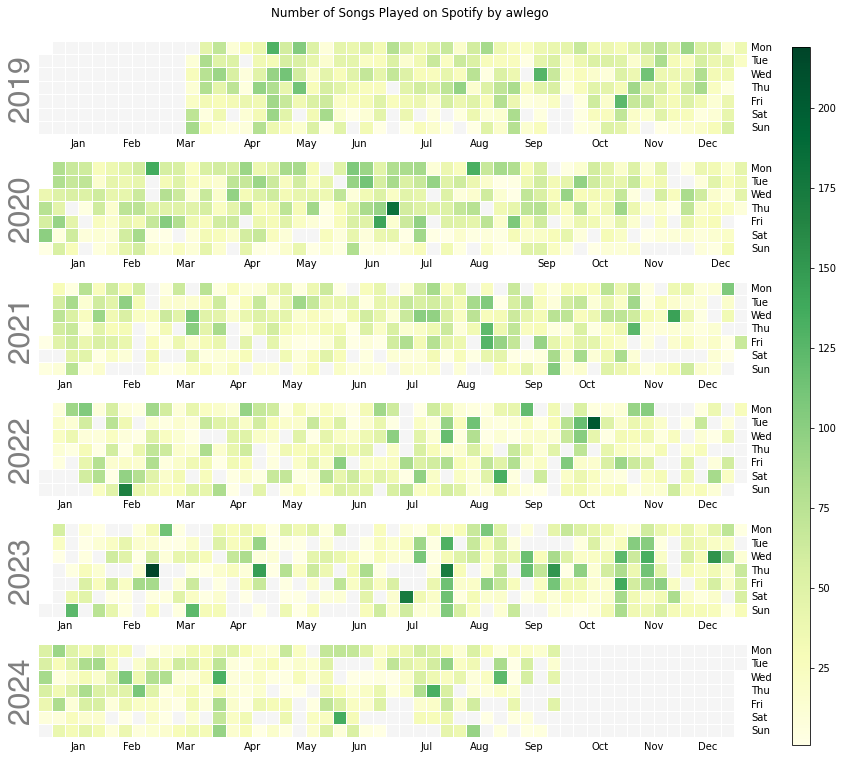

In [48]:
def calc_play_times(history):
    df = history
    df['day_of_week_played_en'] = df['date_played'].apply(lambda x: calendar.day_name[x.weekday()])
    df['day_of_week_played_num'] = df['date_played'].apply(lambda x: x.weekday())
    
    df = df.groupby(['day_of_week_played_num', 'day_of_week_played_en']).count()
    df = df.rename(columns={'day_played': 'play_count'})
    df = df.filter(['play_count'], axis='columns')    
    df.plot.bar(title="Awlego's Spotify Playcount by Day of Week")
    
def calc_cal_heatmap(spotify_history, artist_filter=None):
    spotify_history['day_played_datetime'] = spotify_history['date_played'].dt.date
    if artist_filter:
        spotify_history = spotify_history.where(spotify_history['artist'] == artist_filter).dropna()
    df = spotify_history.groupby('day_played').count()
    
    df = spotify_history.set_index(['date_played'])
    df['number'] = 1
    

    if artist_filter:
        title = f'Number of {artist_filter} Songs Played on Spotify by awlego'
    else:
        title = 'Number of Songs Played on Spotify by awlego'

    ax = calplot.calplot(df['number'], cmap='YlGn', dropzero=True, edgecolor=None, colorbar=True, suptitle=title)
# calc_play_times(spotify_history)
# calc_cal_heatmap(spotify_history)
calc_cal_heatmap(spotify_history, artist_filter=None)

In [49]:
def most_consistently_listened_to_artists(spotify_history):
    df = spotify_history.groupby(['artist', 'day_played_datetime'])['day_played_datetime'].count().reset_index(name="num_artist_play_days")
    df = df.sort_values('num_artist_play_days', ascending=False)
    print(df[0:10])

most_consistently_listened_to_artists(spotify_history)

                   artist day_played_datetime  num_artist_play_days
11786       Hayden Calnin          2023-11-17                    75
20103         Mat Kearney          2019-09-18                    73
29055  Soft Romantic Jazz          2022-12-17                    70
14758         Jon Bellion          2019-04-11                    60
5163    Caroline Polachek          2023-05-04                    55
32705       The Oh Hellos          2019-08-01                    55
30169        Taylor Swift          2019-05-06                    55
36470      Zac Brown Band          2021-11-03                    54
14246           Jim Yosef          2022-09-01                    54
8684           Ed Sheeran          2021-10-30                    54


## 2023 Wrapped

In [54]:
df_2023 = spotify_history.where(spotify_history['date_played'].dt.year == 2023).dropna()

## Number of songs listened to

In [58]:
len(df_2023)


10268

interesting... spotify claims I played 4,599 songs in 2023. I have over 10,000. Someone's data is bad.

## Most played song

In [61]:
calc_play_counts(df_2023).iloc[0]

artist                        Caroline Polachek
song          So Hot You're Hurting My Feelings
play_count                                   42
Name: 538, dtype: object

Okay closer agreement here: spotify says 43 times and agrees that this was my top song

In [63]:
calc_play_counts(df_2023).iloc[0:10]

,artist,song,play_count
538,Caroline Polachek,So Hot You're Hurting My Feelings,42
1819,Kara,WHEN I MOVE,38
4157,eleventyseven,All The Doubt In Town,33
4051,Zac Brown Band,Natural Disaster,32
2003,Lizzy McAlpine,all my ghosts,32
572,Charlie Puth,Charlie Be Quiet!,31
2011,Lizzy McAlpine,erase me,31
514,Caroline Polachek,Blood and Butter,30
1362,Hugh Jackman,From Now On,30
467,Camila Cabello,Bam Bam (feat. Ed Sheeran),30


this more or less matches spotify's records

## Number of unique artists I listened to this year

In [66]:
# spotify says I listened to 2,342 artists this year.
len(df_2023['artist'].unique())

1560

I bet the difference is I'm only tracking the first artist on a track

## Favorite artists this year

In [68]:
get_most_played_artists(df_2023)[0:10]

/var/folders/_4/45mv5nqd1m1_xtw1k2q21zdc0000gn/T/ipykernel_31098/2322836080.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  return play_counts_df.groupby('artist').sum().sort_values('play_count', ascending=False)


,play_count
artist,
Lizzy McAlpine,316
Caroline Polachek,269
Taylor Swift,246
Ed Sheeran,185
Tessa Violet,141
Zac Brown Band,138
The Oh Hellos,131
dodie,121
Noah Kahan,120


/var/folders/_4/45mv5nqd1m1_xtw1k2q21zdc0000gn/T/ipykernel_31098/2322836080.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  return play_counts_df.groupby('artist').sum().sort_values('play_count', ascending=False)
/Users/awlego/Repositories/spotify_sync/env3.10/lib/python3.10/site-packages/calplot/calplot.py:153: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  plot_data = by_day.pivot('day', 'week', 'data').values[::-1]
/Users/awlego/Repositories/spotify_sync/env3.10/lib/python3.10/site-packages/calplot/calplot.py:157: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  fill_data = by_day.pivot('day', 'week', 'fill').values[::-1]
/Users/awlego/Repositories/spotify_sync/env3.10/lib/python3.10/

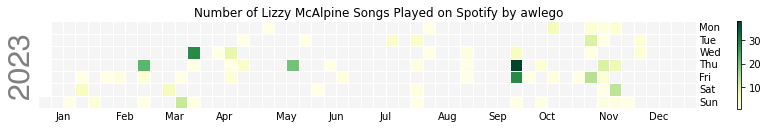

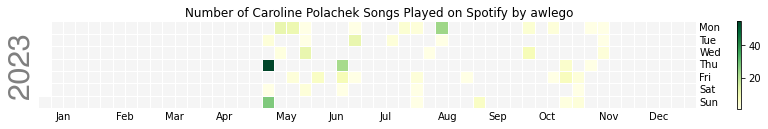

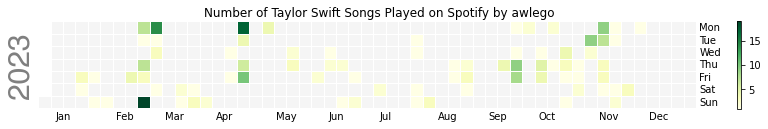

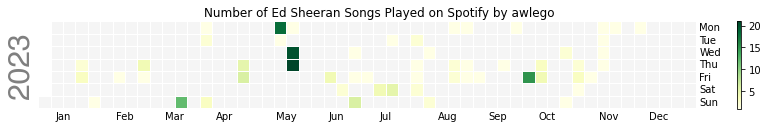

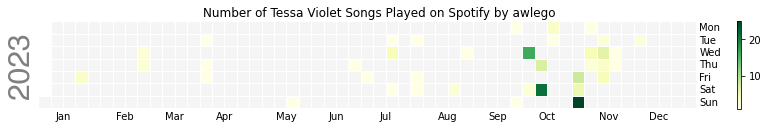

In [101]:
for i in range(5):
    calc_cal_heatmap(df_2023, artist_filter=get_most_played_artists(df_2023).iloc[i].name)


In [87]:
def peak_listening_month(spotify_history, artist):
    spotify_history['day_played_datetime'] = pd.to_datetime(spotify_history['day_played_datetime'])
    spotify_history['month'] = spotify_history['day_played_datetime'].dt.month
    artist_history = spotify_history.where(spotify_history['artist'] == artist)
    play_counts_df =  artist_history.groupby(["month"]).size().rename('play_count').reset_index().sort_values('play_count', ascending=False)
    return play_counts_df
    # return play_counts_df.groupby('artist').sum().groupby("month").sum().sort_values('play_count', ascending=False)
peak_listening_month(df_2023, get_most_played_artists(df_2023).iloc[0].name)

/var/folders/_4/45mv5nqd1m1_xtw1k2q21zdc0000gn/T/ipykernel_31098/2322836080.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  return play_counts_df.groupby('artist').sum().sort_values('play_count', ascending=False)


,month,play_count
8,9.0,73
10,11.0,66
2,3.0,49
1,2.0,29
9,10.0,26
4,5.0,22
3,4.0,18
6,7.0,14
0,1.0,10
7,8.0,5


In [88]:
MONTH_NUMBER_TO_NAME = {
    "1": "January",
    "2": "February",
    "3": "March",
    "4": "April",
    "5": "May",
    "6": "June",
    "7": "July",
    "8": "August",
    "9": "September",
    "10": "October",
    "11": "November",
    "12": "December",
}

In [100]:
for i in range(5):
    peak_artist = get_most_played_artists(df_2023).iloc[i].name
    df = peak_listening_month(df_2023, peak_artist)
    peak_month_name = MONTH_NUMBER_TO_NAME[str(int(df.iloc[0].month))]
    peak_month_playcounts= [str(int(df.iloc[0].play_count))]
    print(f"You listened to {peak_artist} {peak_month_playcounts} times in {peak_month_name}")

You listened to Lizzy McAlpine ['73'] times in September
You listened to Caroline Polachek ['128'] times in May
You listened to Taylor Swift ['57'] times in February
You listened to Ed Sheeran ['61'] times in May
You listened to Tessa Violet ['71'] times in October


/var/folders/_4/45mv5nqd1m1_xtw1k2q21zdc0000gn/T/ipykernel_31098/2322836080.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  return play_counts_df.groupby('artist').sum().sort_values('play_count', ascending=False)
/var/folders/_4/45mv5nqd1m1_xtw1k2q21zdc0000gn/T/ipykernel_31098/2322836080.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  return play_counts_df.groupby('artist').sum().sort_values('play_count', ascending=False)
/var/folders/_4/45mv5nqd1m1_xtw1k2q21zdc0000gn/T/ipykernel_31098/2322836080.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future 

## What day of the week do I listen to the most music

In [44]:
DAY_NAMES_DICT = dict(zip(calendar.day_name, range(7)))
print(DAY_NAMES_DICT)

import pandas as pd

def play_counts_by_dow(df):
    '''Calculates the number of plays on each day of the week, returning them sorted by day of week.'''
    df['day_played_datetime'] = pd.to_datetime(df['day_played_datetime'])
    df['weekday'] = df['day_played_datetime'].dt.strftime('%A')

    # Define the correct order for the days of the week
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Group by weekday and count the plays
    df = df.groupby(['weekday']).size().rename('play_count')

    # Convert the index to a CategoricalIndex with the defined order
    df.index = pd.CategoricalIndex(df.index, categories=days, ordered=True)

    # Sort by the index (i.e., day of the week)
    df = df.sort_index()

    return df



dow_df = play_counts_by_dow(df_2023)
dow_df.plot.bar(x='weekday', xlabel="Weekday", ylabel='Song Play Count')


{'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}


NameError: name 'df_2023' is not defined

## 2023 heatmap

/Users/awlego/Repositories/spotify_sync/env3.10/lib/python3.10/site-packages/calplot/calplot.py:153: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  plot_data = by_day.pivot('day', 'week', 'data').values[::-1]
/Users/awlego/Repositories/spotify_sync/env3.10/lib/python3.10/site-packages/calplot/calplot.py:157: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  fill_data = by_day.pivot('day', 'week', 'fill').values[::-1]
/Users/awlego/Repositories/spotify_sync/env3.10/lib/python3.10/site-packages/calplot/calplot.py:193: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  ax.set_xticks([by_day.loc[pd.Timestamp(


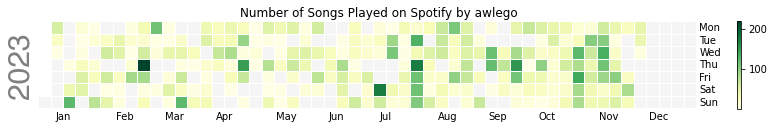

In [202]:
calc_cal_heatmap(df_2023, artist_filter=None)

/Users/awlego/Repositories/spotify_sync/env3.10/lib/python3.10/site-packages/calplot/calplot.py:153: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  plot_data = by_day.pivot('day', 'week', 'data').values[::-1]
/Users/awlego/Repositories/spotify_sync/env3.10/lib/python3.10/site-packages/calplot/calplot.py:157: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  fill_data = by_day.pivot('day', 'week', 'fill').values[::-1]
/Users/awlego/Repositories/spotify_sync/env3.10/lib/python3.10/site-packages/calplot/calplot.py:193: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  ax.set_xticks([by_day.loc[pd.Timestamp(
/Users/awlego/Repositories/spotify_sync/env3.10/lib/python3.10/site-packages/calplot/calplot.py:153: FutureWarning: In a future version of pandas a

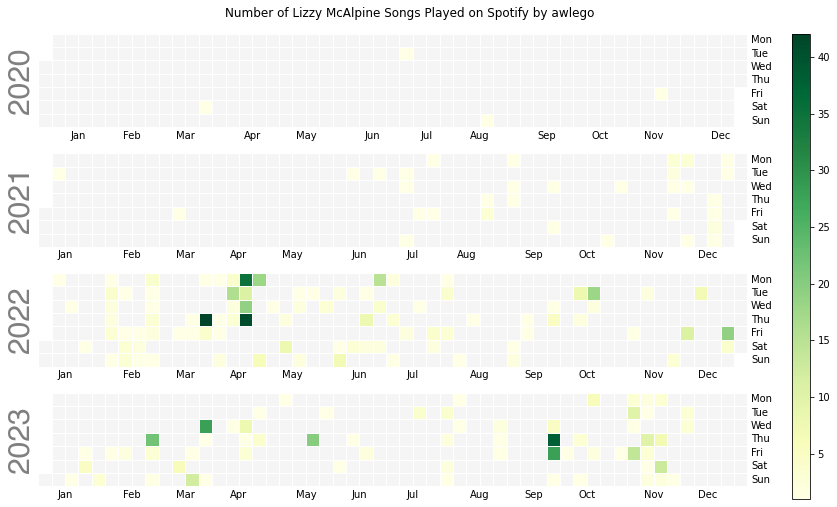

In [205]:
calc_cal_heatmap(spotify_history, artist_filter="Lizzy McAlpine")

In [209]:
df_2023.where(df_2023['song'] == "The Joker And The Queen").dropna()

,artist,album,song,date_played,day_played,day_played_datetime,month,day,weekday,weekday_num


# Stop
this should throw an error so you can hit "run all cells" without worrying about the playground going wild

In [20]:
stop

NameError: name 'stop' is not defined

# Playground
below here I promise nothing

In [ ]:
#todo
# combine the multiple versions of songs together and pick the one that I have saved and if not saved then the one that I have more playcounts for.


In [ ]:
def find_standout_songs(spotify_history, timewindow):
    df = calc_play_counts(spotify_history)
    
# find_standout_songs(spotify_history)

In [ ]:
# def update_recently_played(username, token, playlist_id):
    
def recently_played():
    """Calculates the last 50 songs played."""
    pass

In [ ]:
def save_all_liked_songs():
    """save a list of all the songs I've added to my library so if I ever lose it
    I could rebuild my library"""
    sp = spotipy.Spotify()

    scope = 'user-library-read'

    username = SPOTIFY_USERNAME

    token = util.prompt_for_user_token(username, scope)

    if token:
        sp = spotipy.Spotify(auth=token)
        results = sp.current_user_saved_tracks()
        for item in results['items']:
            track = item['track']
            print(track['name'] + ' - ' + track['artists'][0]['name'])
    else:
        print("Can't get token for", username)
    

## testing directly getting my lastfm data

In [ ]:
requests.get('https://api.github.com')

In [ ]:
data = {
    'method':'user.getrecenttracks',
    'user':username,
    'api_key':'e8db1a5e26f01ca1abae47d64738e9b4',
    'limit':200,
    'page': 1,
}

response = requests.post("https://ws.audioscrobbler.com/2.0/", data=data)
# json_response = response.json()

In [ ]:
response.status_code

In [ ]:
import xml.etree.ElementTree as ET
import json

!pip3 install xmljson
from xmljson import badgerfish as bf

In [ ]:
tree = ET.fromstring(response.text)
tree

In [ ]:
temp = json.dumps(bf.data(tree))
df = pd.read_json(temp)

In [ ]:
df

In [ ]:
temp

In [ ]:
scope = 'user-read-recently-played'
token = util.prompt_for_user_token(username, scope)
header = {
   "access_token": token,
   'Authorization': 'Bearer {0}'.format(token),
}
data = {
    'limit': 50
}

# note: songs have to finish for this to catch them.
response = requests.get('https://api.spotify.com/v1/me/player/recently-played',
                        headers=header,
                        params=data)

In [ ]:
print(response.status_code)
for item in response.json()['items']:
    print(item['track']['name'])
#     print(item['track'])

In [ ]:
twenty_twenty_history = spotify_history.where(spotify_history['date_played'].dt.year == 2020).dropna()

In [198]:
history_2022 = spotify_history.where(spotify_history['date_played'].dt.year == 2022).dropna()

In [ ]:
calc_most_listened_all_time(twenty_twenty_history)

In [ ]:
get_most_played_artists(twenty_twenty_history)[0:10]

In [ ]:
get_most_played_artists(spotify_history)[0:10]

In [ ]:
history_2021 = spotify_history.where(spotify_history['date_played'].dt.year == 2021).dropna()

In [ ]:
calc_most_listened_all_time(history_2021)

In [25]:
get_most_played_artists(history_2022)[0:15]

/var/folders/_4/45mv5nqd1m1_xtw1k2q21zdc0000gn/T/ipykernel_95975/2322836080.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  return play_counts_df.groupby('artist').sum().sort_values('play_count', ascending=False)


,play_count
artist,
Lizzy McAlpine,382
Charlie Puth,287
Zac Brown Band,270
Penny and Sparrow,244
Taylor Swift,181
dodie,176
Camila Cabello,166
Ed Sheeran,165
Bon Iver,144


In [24]:
history_2022

,artist,album,song,date_played,day_played,day_played_datetime
0,Neural Cloud,Up To The Cloud,Up To The Cloud,2022-11-29 15:29:00-08:00,2022-11-29,2022-11-29
1,Alonestar,Real Life [Jethro Sheeran Remix],Real Life [Jethro Sheeran Remix],2022-11-29 15:25:00-08:00,2022-11-29,2022-11-29
2,J. Maya,Three Specters,Three Specters,2022-11-29 15:21:00-08:00,2022-11-29,2022-11-29
3,Muse,Ghosts (How Can I Move On) [feat. Elisa],Ghosts (How Can I Move On) [feat. Elisa],2022-11-29 15:17:00-08:00,2022-11-29,2022-11-29
4,The Paper Kites,Woodland,Willow Tree March,2022-11-27 21:44:00-08:00,2022-11-27,2022-11-27
...,...,...,...,...,...,...
10211,Laura Bell Bundy,Women of Tomorrow,Get It Girl You Go,2022-01-03 21:27:00-08:00,2022-01-03,2022-01-03
10212,Avi Kaplan,I'll Get By,I'll Get By,2022-01-03 21:23:00-08:00,2022-01-03,2022-01-03
10213,Lil Nas X,MONTERO (Call Me by Your Name),MONTERO (Call Me by Your Name),2022-01-03 21:21:00-08:00,2022-01-03,2022-01-03
10214,K/DA,ALL OUT,DRUM GO DUM,2022-01-03 21:18:00-08:00,2022-01-03,2022-01-03


In [29]:
calc_play_counts(history_2022)[0:30]


,artist,album,song,play_count
3890,Zac Brown Band,Uncaged,Natural Disaster,65
2661,Penny and Sparrow,Finch,Don't Wanna Be Without Ya,50
3893,Zac Brown Band,Uncaged,The Wind,46
2003,Lizzy McAlpine,erase me (feat. Jacob Collier),erase me (feat. Jacob Collier),42
2000,Lizzy McAlpine,all my ghosts,All My Ghosts,41
576,Charlie Puth,Charlie Be Quiet!,Charlie Be Quiet!,37
2147,Marianas Trench,Astoria,Who Do You Love,34
1725,K/DA,ALL OUT,DRUM GO DUM,34
510,Camila Cabello,Familia,Bam Bam (feat. Ed Sheeran),33
3781,Wilder Woods,Wilder Woods,Supply & Demand,33


In [38]:
header_names = ["full_date", "date", "time", "mood", "activities", "notes_title", "note"]
mood_history = pd.read_csv("daylio_export_2023_10_06.csv", header=0, names=header_names)


In [33]:
mood_history

,full_date,date,time,mood,activities,notes_title,note
2023-10-06,Oct 6,Friday,1:16 AM,rad,date | movies & tv | gaming | good sleep | hom...,NaN,NaN
2023-10-05,Oct 5,Thursday,2:33 AM,good,friends | gaming | project | good sleep | medi...,NaN,NaN
2023-10-04,Oct 4,Wednesday,2:53 AM,good,reading | gaming | board games | medium sleep ...,NaN,NaN
2023-10-03,Oct 3,Tuesday,2:42 AM,good,friends | movies & tv | reading | gaming | goo...,NaN,NaN
2023-10-02,Oct 2,Monday,2:12 AM,meh+,friends | date | movies & tv | reading | gamin...,NaN,NaN
...,...,...,...,...,...,...,...
2022-11-09,Nov 9,Wednesday,1:00 AM,rad,date | movies & tv | gaming | good sleep | hom...,NaN,NaN
2022-11-08,Nov 8,Tuesday,1:00 AM,meh,movies & tv | gaming | project | medium sleep ...,NaN,NaN
2022-11-06,Nov 6,Sunday,11:59 PM,rad,friends | party | gaming | bad sleep | homemad...,NaN,NaN
2022-11-06,Nov 6,Sunday,9:33 AM,rad,friends | party | gaming | bad sleep | homemad...,NaN,NaN


In [42]:
mood_history.index

Index(['2023-10-06', '2023-10-05', '2023-10-04', '2023-10-03', '2023-10-02',
       '2023-10-01', '2023-09-30', '2023-09-29', '2023-09-28', '2023-09-27',
       ...
       '2022-11-14', '2022-11-13', '2022-11-12', '2022-11-11', '2022-11-10',
       '2022-11-09', '2022-11-08', '2022-11-06', '2022-11-06', '2022-11-05'],
      dtype='object', length=364)

In [43]:
mood_history.index = pd.to_datetime(mood_history.index)

In [45]:
mood_history["true_date"] = mood_history.index - pd.Timedelta(days=1)

In [80]:
simple_mood_history = mood_history[["true_date", "mood"]]
simple_mood_history = simple_mood_history.set_index("true_date")
simple_mood_history

,mood
true_date,
2023-10-05,rad
2023-10-04,good
2023-10-03,good
2023-10-02,good
2023-10-01,meh+
...,...
2022-11-08,rad
2022-11-07,meh
2022-11-05,rad


In [151]:
def get_genre(artist_name):
    sp = spotipy.Spotify(auth=token)  
    results = sp.search(q='artist:' + artist_name, type='artist')
    artist_id = results['artists']['items'][0]['id']  # Take the ID of the top result
    artist = sp.artist(artist_id)
    genres = artist['genres']
    return genres
# get_genre("Dodie")

In [169]:
def num_songs_played_by_date(spotify_history, artist_filter=None):
    spotify_history['day_played_datetime'] = spotify_history['date_played'].dt.date
    if artist_filter:
        spotify_history = spotify_history.where(spotify_history['artist'] == artist_filter).dropna()
    df = spotify_history.groupby('day_played_datetime').count()
    df = df.rename(columns={"artist": "num_songs_played"})
    return df["num_songs_played"]

def get_all_artists_genres(spotify_history):
    artist_genres = {}
    artists = spotify_history["artist"].unique()
    for artist in artists:
        try:
            artist_genres[artist] = get_genre(artist)
        except Exception as e:
            print(f"An error occurred: {e}")
            continue
    return artist_genres

def genre_plays_per_day(spotify_history):
    spotify_history['day_played_datetime'] = spotify_history['date_played'].dt.date
    print(spotify_history.groupby("artist").count())
#     print(spotify_history.columns)

# print(num_songs_played_by_date(spotify_history, artist_filter="Taylor Swift"))
# print(genre_plays_per_day(spotify_history))
artist_genres = get_all_artists_genres(spotify_history)

An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error occurred: list index out of range
An error oc

In [170]:
artist_genres

{'Emmylou Harris': ['country rock',
  'folk',
  'lilith',
  'melancholia',
  'singer-songwriter'],
 'Billy Strings': ['jam band',
  'jamgrass',
  'new americana',
  'progressive bluegrass'],
 'Molly Tuttle': ['new americana', 'progressive bluegrass'],
 'Whitney Rose': ['austin singer-songwriter', 'canadian contemporary country'],
 'Andy Hall': ['instrumental bluegrass'],
 'Sarah Jarosz': ['folk',
  'indie folk',
  'new americana',
  'progressive bluegrass'],
 'Steep Canyon Rangers': ['banjo',
  'bluegrass',
  'neo-traditional bluegrass',
  'progressive bluegrass'],
 'Chatham Rabbits': ['modern old-time'],
 'Sierra Ferrell': ['alternative americana', 'new americana'],
 'Susto': ['deep new americana', 'south carolina indie'],
 'Mipso': ['new americana',
  'north carolina roots',
  'progressive bluegrass',
  'stomp and holler'],
 'The Pink Stones': ['alternative country'],
 'Rachel Baiman': ['neo-traditional bluegrass'],
 'Mumford & Sons': ['modern folk rock',
  'modern rock',
  'neo mell

['alt z', 'indie pop', 'pov: indie']

In [145]:
token

'BQDgnUUa3hNvO_W_aIExLQx1ptHoyF8cz4KrlxtkLH84HBYByr4gC0iqBjGd4ty_QUn_u9kWk-_ZMOWArrd9LOLKzJMI5Dk-ZjVX5AUYvMCI3lB7VvA3hxkeF9T6T1IGO0GX12Q1zUi3CS66xDUxHqMqwTZUvEb0msAjOZQTZ9xCMiHwI1g1jqy9xddpo6fL3u6GHWD_-WEG6TwKiqjTSASiqQ'

In [111]:
result = simple_mood_history.join(num_songs_played_by_date(spotify_history), how='outer')

In [112]:
result = result.dropna()
result

,mood,num_songs_played
2022-11-04,good,64.0
2022-11-07,meh,102.0
2022-11-08,rad,35.0
2022-11-09,good,35.0
2022-11-10,good,8.0
...,...,...
2023-09-28,good,1.0
2023-09-29,good,38.0
2023-09-30,rad,26.0
2023-10-01,meh+,8.0


In [171]:
result.mood.unique()

array(['good', 'meh', 'rad', 'bad', 'S+', 'meh+'], dtype=object)

In [90]:
mood_mapping = {
    'S+':5,
    'rad':4,
    'good':3,
    'meh+':2,
    'meh':1,
    'bad':0,
}

In [114]:
correlation = result['mood'].map(mood_mapping).corr(result['num_songs_played'])
correlation

-0.0047747569355806214

In [117]:
result.groupby("mood").mean("num_songs_played")


,num_songs_played
mood,
S+,82.625000
bad,36.500000
good,36.230769
meh,70.000000
meh+,32.500000
rad,29.524390


looks like no correlation

In [23]:
for i in range(100):
    print(spotify_history.iloc[i])

artist                 Penny and Sparrow
album                              Finch
song           Don't Wanna Be Without Ya
date_played    2024-09-27 15:05:00-07:00
Name: 1, dtype: object
artist                            Tori Kelly
album                                   Tori
song           young gun (feat. Jon Bellion)
date_played        2024-09-27 15:02:00-07:00
Name: 2, dtype: object
artist                    Zac Brown Band
album                            Uncaged
song                            The Wind
date_played    2024-09-27 14:59:00-07:00
Name: 3, dtype: object
artist                 Penny and Sparrow
album                          Olly Olly
song                              Gogogo
date_played    2024-09-27 14:55:00-07:00
Name: 4, dtype: object
artist                      Taylor Swift
album                           folklore
song                               peace
date_played    2024-09-27 14:51:00-07:00
Name: 5, dtype: object
artist                    Zac Brown Band
album   